# Library Import

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
import matplotlib.pyplot as plt
import hdbscan
import torch
import torch.nn as nn
import seaborn as sns

In [2]:
df = pd.read_csv('trades_1.csv')

# Data Validation and Analysis

In [3]:
len(df)

88691

In [4]:
df = df.drop_duplicates()

After removing duplicate rows, we see that the dataframe still has the same length, indicating that no duplicate rows existed.

In [5]:
len(df)

88691

Let's take a look at the data and the features we will work with. We see the id, which I assume is the id for the trade, while the portfolio id is an identificator for the user account so to speak. The rest of the data is alphanumeric data pertaining the transaction.

In [6]:
df.head()

,id,portfolio_id,instrument_id,executed_at,quantity,price,total
0,4de3cec5-6527-4a6d-bc3e-e1037f4bbe58,170867ad-9865-466e-bdf8-5e3ea551344c,IE00B5BMR087,2018-07-30 05:09:57.383421,8.0,235.630,1885.04
1,a4171035-ebdf-43b3-b31e-d333594be91f,170867ad-9865-466e-bdf8-5e3ea551344c,DE0007164600,2018-07-30 05:32:06.551758,5.0,101.953,509.77
2,4d1148a7-e031-47e7-8841-8da3828212e1,38490408-1aa8-419e-b5ac-ca96c471a443,DE0006048432,2018-07-30 05:48:37.570582,10.0,107.586,1075.86
3,35a02e62-1f60-4ca4-a391-24985837fc50,38490408-1aa8-419e-b5ac-ca96c471a443,IE00B4L5Y983,2018-07-30 05:51:47.623352,50.0,48.506,2425.30
4,1427141a-f2d9-4e4a-8b51-bfb173314af0,7c1f6387-9b6d-43e2-aba3-38c548f9dfb6,DE000ZAL1111,2018-07-30 05:52:21.263454,20.0,49.816,996.32


Pandas describe function makes it possible to look at standard statistical properties of numeric features, so let's do that:

For the quantity feature, I notice 2 things. First the minimum value is at minus 284, which logically should not be possible. Second, the maximum value is at 1 million, which might be possible but seems highly improbable. 

As far as the price and the total are concerned, the minimum here is at 0. Now, I lack the domain knowledge to certainly say that this is impossible, but common sense tells me that you cannot buy a stock or financial instruments can be bought at a price of 0.

So, let's keep these things in mind.

In [7]:
df.describe()

,quantity,price,total
count,88691.000000,88691.000000,88691.000000
mean,571.653896,170.493957,2165.574307
std,8770.273739,333.542551,1856.706524
min,-284.000000,0.000000,0.000000
25%,6.000000,21.249000,613.070000
50%,20.000000,70.920000,1659.180000
75%,73.000000,178.776000,3642.260000
max,1000000.000000,5549.330000,26138.490000


Next, we check for missing values and see that there none.

In [8]:
df.isna().sum()

id               0
portfolio_id     0
instrument_id    0
executed_at      0
quantity         0
price            0
total            0
dtype: int64

In [9]:
def isolation_outlier(df, cont, cols=None):
    print('dataset with outliers:', len(df))
    isof = IsolationForest(max_samples=1000, contamination=cont/100)
    if cols == None:
        isof.fit(df.select_dtypes(include=np.number))
        listpred = isof.predict(df.select_dtypes(include=np.number))
    else:
        isof.fit(df[cols])
        listpred = isof.predict(df[cols])
    df['outlier'] = listpred
    df = df.loc[df['outlier'] == 1]
    df.drop('outlier', axis=1, inplace=True)
    print('dataset without outliers:', len(df))
    return df

Next, we deal with outliers. 

Outliers are a tricky topic, because oftentimes a statistical outlier might not be an outlier from a business perspective and vice versa. Outliers can often be valid, uncorrupted data, which simply represents an edge case for a business. Still, outliers can have a negative impact on a model performance, so I have chosen to remove a conservative amount using an algorithmic approach as my domain and business knowledge is limited. A huge advantage of the isolation forest algorithm is that it can tackle outliers in a multivariate fashion, which comes in very handy for bigger dimension datasets.

Please note that Isolation Forest is unsupervised, so applying it on the whole data set will not result in data leakage!

We aim to remove around 5% of the data. The 5% threshold is a heuristic measure, which for the purpose of this showcase should be a good measure.

In [10]:
df_out = isolation_outlier(df, 5)

dataset with outliers: 88691
dataset without outliers: 84258


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We then check, how our outlier detection has affected the data:
    
While the maximum values for the features have been curtailed successfully to reasonable numbers, the minimum values remain unchanged. This indicates that only a small number of rows are affected and can easily be removed manually without losing a significant amount of data.

Another big change is the mean of the quantity feature, which went from 572 to 183. Changes were also noted on the price, going from 170 to 118 and the total, which decreased from 2166 to 2078.

In [11]:
df_out.describe()

,quantity,price,total
count,84258.000000,84258.000000,84258.000000
mean,157.877646,122.541128,2077.742172
std,550.109573,211.419150,1677.242572
min,-284.000000,0.000000,0.000000
25%,8.000000,21.090000,578.917500
50%,20.000000,67.892000,1583.370000
75%,73.000000,162.879000,3518.537500
max,10000.000000,1733.131000,7784.000000


Checking on correlations between the features, it becomes clear, that there are only very weak correlations, which do not exceed 0.15.

In [12]:
df_out.corr()

,quantity,price,total
quantity,1.000000,-0.148483,0.192618
price,-0.148483,1.000000,0.152978
total,0.192618,0.152978,1.000000


Let's visualize the distribution of our features. For the quantity of stock, we see that a massive majority of trades are located in the corridor of 0 and 100 stocks and that only few trades involved a higher quantity. The quantity of 10 is by far the most frequent value at 10.000 trades.

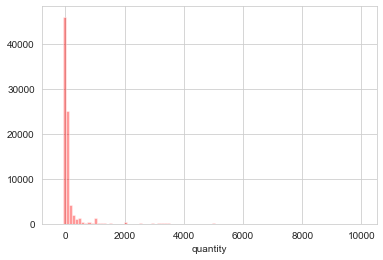

In [13]:
sns.set_style('whitegrid') 
sns.distplot(df_out['quantity'], kde = False, color ='red', bins = 100) 

In [14]:
df_out['quantity'].value_counts()

10.0      10054
5.0        6146
20.0       6000
100.0      4625
50.0       4464
          ...  
645.0         1
1915.0        1
2650.0        1
612.0         1
1697.0        1
Name: quantity, Length: 1252, dtype: int64

Regarding the price. A quarter of trades involve low price stock and generally speaking the vast majority of trades involved stock at prices lower than 250 euro, indicating a clear user preference on lower priced stock. This should be further examined. 

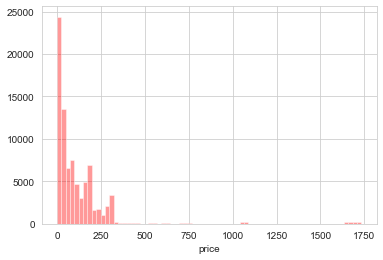

In [15]:
sns.set_style('whitegrid') 
sns.distplot(df_out['price'], kde = False, color ='red', bins = 70) 

Looking at at the total, we see more balanced picture with total amount spent per trade. The distribution curve is concave, indicating similar actvity between 1 and 5000 euro.

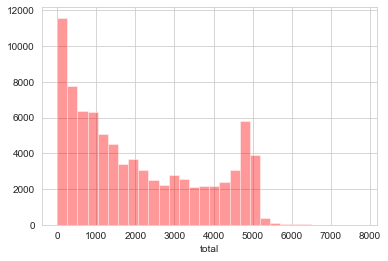

In [16]:
sns.set_style('whitegrid') 
sns.distplot(df_out['total'], kde = False, color ='red', bins = 30) 

Returning to the issue we ran into with the negative value for stock quantity. We see that the number of rows affected is only two. So we simply discard them as this has no impact on further steps.

# Time Series Analysis - Total Volume, Quantity, Price

In [17]:
df_out['executed_at_date'] = pd.to_datetime(df_out['executed_at']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
grp_total = df_out[['executed_at_date', 'total']].groupby(['executed_at_date']).mean()
grp_total['total'] = grp_total['total'].astype(int)

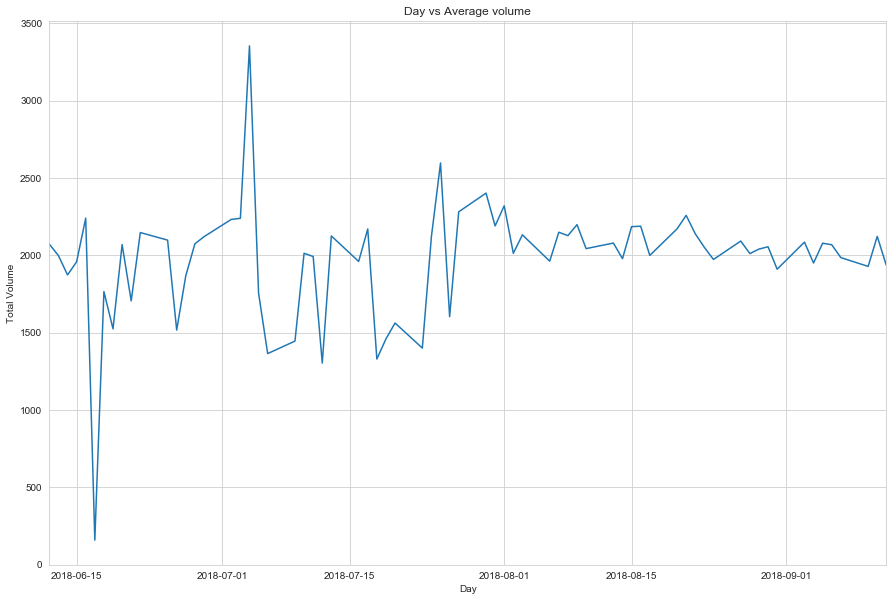

In [24]:
plt.figure(figsize=(15,10))
plt.title('Day vs Average volume')
plt.ylabel('Average Volume')
plt.xlabel('Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(grp_total['total'])

In [25]:
grp_quantity = df_out[['executed_at_date', 'quantity']].groupby(['executed_at_date']).mean()
grp_quantity['total'] = grp_quantity['quantity'].astype(int)

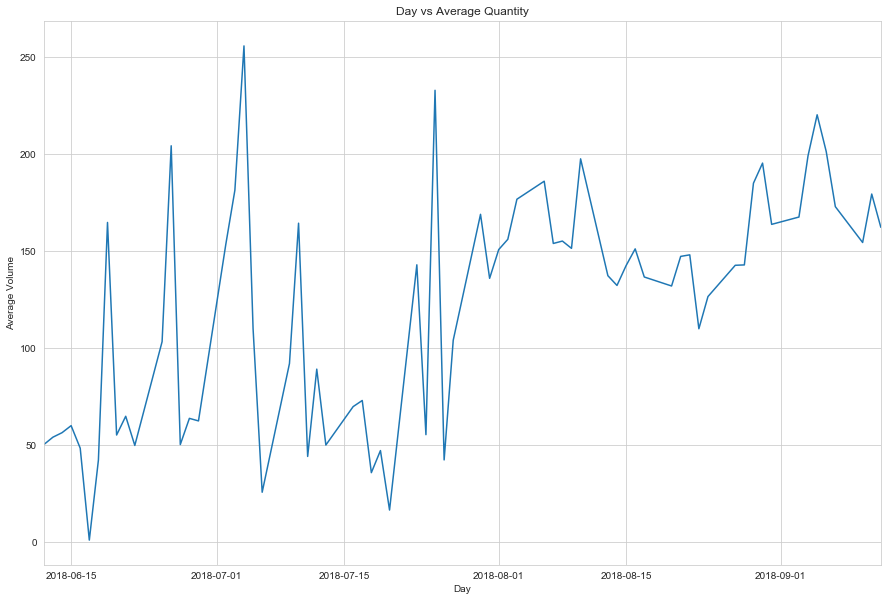

In [27]:
plt.figure(figsize=(15,10))
plt.title('Day vs Average Quantity')
plt.ylabel('Average Volume')
plt.xlabel('Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(grp_quantity['quantity'])

In [28]:
grp_price = df_out[['executed_at_date', 'price']].groupby(['executed_at_date']).mean()
grp_price['total'] = grp_price['price'].astype(int)

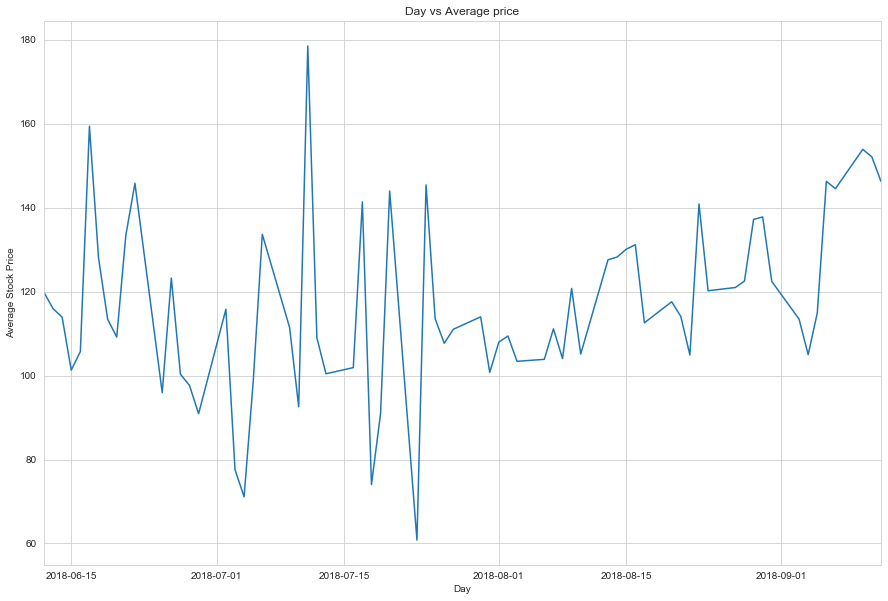

In [29]:
plt.figure(figsize=(15,10))
plt.title('Day vs Average price')
plt.ylabel('Average Stock Price')
plt.xlabel('Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(grp_price['price'])

In [ ]:
df_out['executed_at_date']

In [39]:
df_284 = df_out[df_out['quantity'] < 0]

In [40]:
df_284.describe()

,quantity,price,total
count,2.00000,2.000000,2.000000
mean,-152.00000,29.185500,2903.215000
std,186.67619,16.423969,2951.796045
min,-284.00000,17.572000,815.980000
25%,-218.00000,23.378750,1859.597500
50%,-152.00000,29.185500,2903.215000
75%,-86.00000,34.992250,3946.832500
max,-20.00000,40.799000,4990.450000


In [41]:
df_out = df_out[df_out['quantity'] > 0]
df_out = df_out[df_out['price'] > 0]
df_out = df_out[df_out['total'] > 0]

In [42]:
len(df_out)

84258

# Feature Engineering

In [43]:
def time_decon(df, col):
    if df[col].dtype != 'datetime64[ns]':
        df[col] = pd.to_datetime(df[col])
    df[col+'_day'] = df[col].dt.day
    df[col+'_day_name'] = df[col].dt.day_name()
    df[col+'_month'] = df[col].dt.month
    df[col+'_year'] = df[col].dt.year
    return df

We should also engineer some features, namely from execution timestamp as well as the instrument id. First, we deconstruct the timestamp into its constituent parts - day name, month, day of month.

In [44]:
df_time = time_decon(df_out, 'executed_at')

In [45]:
df_time.head()

,id,portfolio_id,instrument_id,executed_at,quantity,price,total,executed_at_day,executed_at_day_name,executed_at_month,executed_at_year
0,4de3cec5-6527-4a6d-bc3e-e1037f4bbe58,170867ad-9865-466e-bdf8-5e3ea551344c,IE00B5BMR087,2018-07-30 05:09:57.383421,8.0,235.630,1885.04,30,Monday,7,2018
1,a4171035-ebdf-43b3-b31e-d333594be91f,170867ad-9865-466e-bdf8-5e3ea551344c,DE0007164600,2018-07-30 05:32:06.551758,5.0,101.953,509.77,30,Monday,7,2018
2,4d1148a7-e031-47e7-8841-8da3828212e1,38490408-1aa8-419e-b5ac-ca96c471a443,DE0006048432,2018-07-30 05:48:37.570582,10.0,107.586,1075.86,30,Monday,7,2018
3,35a02e62-1f60-4ca4-a391-24985837fc50,38490408-1aa8-419e-b5ac-ca96c471a443,IE00B4L5Y983,2018-07-30 05:51:47.623352,50.0,48.506,2425.30,30,Monday,7,2018
4,1427141a-f2d9-4e4a-8b51-bfb173314af0,7c1f6387-9b6d-43e2-aba3-38c548f9dfb6,DE000ZAL1111,2018-07-30 05:52:21.263454,20.0,49.816,996.32,30,Monday,7,2018


A little examination shows, that almost 60k of the 84k trades have been made in August. Since only 4 months of data have been captured, we cannot spot any seasonality as this would require data for at least an entire year.

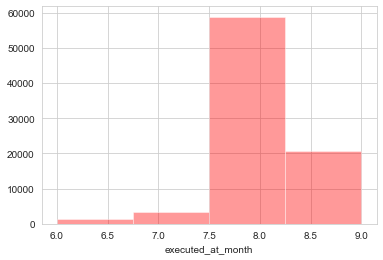

In [46]:
sns.set_style('whitegrid') 
sns.distplot(df_time['executed_at_month'], kde = False, color ='red', bins = 4) 

Day of the month shows that on average, there have been more trades in the first half of a month, compared to the latter half. This could possibly have to do with more disposable income being available at the beginning of a month, which is then spend on investment such as stock or other financial products. This is in an interesting finding and could absolutely be employed for marketing and product design purposes.

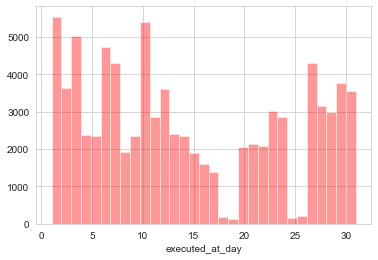

In [48]:
sns.set_style('whitegrid') 
sns.distplot(df_time['executed_at_day'], kde = False, color ='red', bins = 31) 

Next, let's also utilize the instrument id in a useful fashion. As a proxy for it, we can use the frequency of it to indicate whether it is a "mainstream" or "niche" product. 

In [49]:
inst_counts = df_time['instrument_id'].value_counts().to_frame().reset_index()

In [50]:
inst_counts.rename(columns = {'index':'instrument_id', 'instrument_id':'instrument_count'}, inplace = True) 

In [51]:
inst_counts.head()

,instrument_id,instrument_count
0,US0378331005,3913
1,US88160R1014,3007
2,US64110L1061,2410
3,DE0007472060,2341
4,US30303M1027,1809


The same is being done for the weekday name, as we can see that most trades occur on wednesdays, while friday shows the least activity.

In [52]:
day_counts = df_time['executed_at_day_name'].value_counts().to_frame().reset_index()

In [53]:
day_counts.rename(columns = {'index':'executed_at_day_name', 'executed_at_day_name':'dayname_count'}, inplace = True) 

In [54]:
day_counts.head()

,executed_at_day_name,dayname_count
0,Wednesday,20549
1,Monday,17482
2,Tuesday,16650
3,Thursday,15937
4,Friday,13633


And also for the month and the day of the month, we use the frequency as the way to encode this categorical feature.

Sure, variables such as day, week or month are actually ordinal cyclical ones, but keeping them as is will not take into account their cyclical properties. What you could possibly do is use a trigonometric approach by doing something like this:

x_month = sin(2*pi*month/12)

y_month = cos(2*pi*month/12)

But since I am not planning to use a linear regression model, just keeping them as categorical variables is just fine.

In [55]:
month_counts = df_time['executed_at_month'].value_counts().to_frame().reset_index()

In [56]:
month_counts.rename(columns = {'index':'executed_at_month', 'executed_at_month':'month_count'}, inplace = True) 

In [57]:
month_counts.head()

,executed_at_month,month_count
0,8,58852
1,9,20700
2,7,3364
3,6,1342


In [58]:
day_month_counts = df_time['executed_at_day'].value_counts().to_frame().reset_index()

In [59]:
day_month_counts.rename(columns = {'index':'executed_at_day', 'executed_at_day':'day_month_count'}, inplace = True) 

In [71]:
df_counts = pd.merge(df_time, day_counts, on='executed_at_day_name')
df_ints = pd.merge(df_counts, inst_counts, on='instrument_id')
df_months = pd.merge(df_ints, month_counts, on='executed_at_month')
df_day_months = pd.merge(df_months, day_month_counts, on='executed_at_day')


In [72]:
df_day_months.describe()

,quantity,price,total,executed_at_day,executed_at_month,executed_at_year,dayname_count,instrument_count,month_count,day_month_count
count,84258.000000,84258.000000,84258.000000,84258.000000,84258.000000,84258.0,84258.000000,84258.000000,84258.000000,84258.000000
mean,186.230313,118.783381,2072.953607,14.395737,8.173894,2018.0,17149.124261,838.148900,46347.710176,3495.757768
std,751.998136,201.743479,1678.202622,9.850349,0.564865,0.0,2279.042248,1026.743296,19412.568335,1232.587239
min,1.000000,0.001000,0.010000,1.000000,6.000000,2018.0,2.000000,1.000000,1342.000000,123.000000
25%,8.000000,20.605250,578.227500,6.000000,8.000000,2018.0,15937.000000,96.000000,20700.000000,2362.000000
50%,20.000000,66.380000,1572.815000,12.000000,8.000000,2018.0,16650.000000,441.000000,58852.000000,3554.000000
75%,75.000000,161.456250,3520.440000,23.000000,8.000000,2018.0,17482.000000,1032.000000,58852.000000,4308.000000
max,13000.000000,1725.215000,7938.000000,31.000000,9.000000,2018.0,20549.000000,3913.000000,58852.000000,5536.000000


# Data Aggregation, Dimensionality Reduction, Clustering

Moving on to the clustering part, we select the features that we want to perform clustering on.

In [73]:
df_cluster = df_day_months[['quantity', 'price', 'total', 
                                         'dayname_count', 'instrument_count',
                                        'month_count', 'day_month_count', 'portfolio_id']]

In [75]:
df_cluster.head()

,quantity,price,total,dayname_count,instrument_count,month_count,day_month_count,portfolio_id
0,8.0,235.630,1885.04,17482,44,3364,3759,170867ad-9865-466e-bdf8-5e3ea551344c
1,5.0,101.953,509.77,17482,752,3364,3759,170867ad-9865-466e-bdf8-5e3ea551344c
2,5.0,102.479,512.39,17482,752,3364,3759,be810de0-6aea-4a05-977a-b1226c91aba4
3,5.0,102.359,511.79,17482,752,3364,3759,be810de0-6aea-4a05-977a-b1226c91aba4
4,20.0,102.299,2045.98,17482,752,3364,3759,ca9a80c9-0c70-4cc1-a248-0d7b003d20b2


Before we cluster, we check if there is a correlation between any of the newly added features, which does not seem apparent.

In [64]:
df_cluster.corr()

,quantity,price,total,dayname_count,instrument_count,month_count,day_month_count
quantity,1.000000,-0.132149,0.146876,0.001879,-0.094322,-0.008212,0.012764
price,-0.132149,1.000000,0.144639,-0.001669,0.231821,-0.018226,-0.004880
total,0.146876,0.144639,1.000000,0.021076,0.126429,0.016893,0.007137
dayname_count,0.001879,-0.001669,0.021076,1.000000,-0.006491,-0.078697,-0.044896
instrument_count,-0.094322,0.231821,0.126429,-0.006491,1.000000,-0.014782,0.001969
month_count,-0.008212,-0.018226,0.016893,-0.078697,-0.014782,1.000000,-0.052134
day_month_count,0.012764,-0.004880,0.007137,-0.044896,0.001969,-0.052134,1.000000


To create "user profiles", we aggregate the data over the portfolio id. 

In [76]:
d = {'quantity': ['mean', 'sum', 'max', 'min', 'std', 'count'], 
     'price': ['mean', 'sum', 'max', 'min', 'std'],
     'total': ['mean', 'sum', 'max', 'min', 'std'],
     'dayname_count': ['mean', 'max', 'min'],
     'instrument_count': ['mean', 'max', 'min'],
     'month_count': ['mean', 'max', 'min'],
     'day_month_count': ['mean', 'max', 'min'],
    }

cluster_agg = df_cluster.groupby('portfolio_id').agg(d)

In [77]:
cluster_agg.columns = ['_'.join(col) for col in cluster_agg.columns.values]

In [78]:
cluster_agg.head()

,quantity_mean,quantity_sum,quantity_max,quantity_min,quantity_std,quantity_count,price_mean,price_sum,price_max,price_min,...,dayname_count_min,instrument_count_mean,instrument_count_max,instrument_count_min,month_count_mean,month_count_max,month_count_min,day_month_count_mean,day_month_count_max,day_month_count_min
portfolio_id,,,,,,,,,,,,,,,,,,,,,
0022f709-9ce1-41b5-8b89-54741ecae1e7,60.764706,1033.0,400.0,3.0,95.390336,17,103.485059,1759.2460,428.490,6.014,...,13633,396.117647,917,13,58852.000000,58852,58852,1838.588235,2356,1386
00325aba-d537-4bdb-be3c-198132ee691a,145.916667,1751.0,500.0,10.0,182.645438,12,83.461783,1001.5414,207.490,1.452,...,15937,1258.833333,3913,51,55672.666667,58852,20700,3607.416667,4725,2341
0049d3cc-48b0-486e-9f6c-55a29b216d7f,20.000000,80.0,20.0,20.0,0.000000,4,228.458500,913.8340,244.039,188.400,...,16650,3233.500000,3913,3007,20700.000000,20700,20700,3682.250000,5396,2865
008d4cb7-3bf0-4516-ae2d-555fd234d071,39.941748,8228.0,1000.0,1.0,102.194680,206,115.818934,23858.7004,1722.027,0.111,...,13633,893.859223,3913,2,44877.864078,58852,3364,3469.199029,5536,1386
00ac046c-8a70-4ef5-b95b-5352d09c09fb,98.400000,492.0,392.0,15.0,164.425667,5,157.259600,786.2980,320.179,12.741,...,16650,1742.200000,3913,3,20700.000000,20700,20700,2865.000000,2865,2865


We now deal with 3784 rows, indicating around 20 trades per portfolio.

In [79]:
len(cluster_agg)

3784

In [80]:
cluster_agg.isna().sum()
cluster_agg = cluster_agg.fillna(0)

In order for the dimensionality reduction and clustering to work properly, we need to scale the data uniformly.

In [81]:
scal = StandardScaler()
df_scal = scal.fit_transform(cluster_agg)
df_scal = pd.DataFrame(df_scal)

In [82]:
df_scal.columns = cluster_agg.columns

In [83]:
df_scal.head()

,quantity_mean,quantity_sum,quantity_max,quantity_min,quantity_std,quantity_count,price_mean,price_sum,price_max,price_min,...,dayname_count_min,instrument_count_mean,instrument_count_max,instrument_count_min,month_count_mean,month_count_max,month_count_min,day_month_count_mean,day_month_count_max,day_month_count_min
0,-0.359766,-0.312836,-0.376927,-0.085245,-0.393774,-0.157844,-0.280441,-0.221572,-0.202879,-0.231685,...,-0.884504,-0.981021,-1.638993,-0.388780,0.866280,0.614810,1.189702,-1.800666,-1.753462,-1.241701
1,-0.128709,-0.240700,-0.330945,-0.040230,-0.253191,-0.307689,-0.442647,-0.411126,-0.600756,-0.289654,...,0.151662,0.430734,0.844938,-0.316472,0.681785,0.614810,-0.629348,0.093789,0.319434,-0.351096
2,-0.470379,-0.408583,-0.551656,0.024078,-0.547463,-0.547441,0.731952,-0.433068,-0.534955,2.085873,...,0.472317,3.662096,0.844938,5.308349,-1.347663,-1.518424,-0.629348,0.173937,0.906565,0.137571
3,-0.416268,0.410035,-0.101037,-0.098107,-0.382811,5.506299,-0.180526,5.307013,2.125937,-0.306694,...,-0.884504,-0.166513,0.844938,-0.409711,0.055368,0.614810,-1.455911,-0.054245,1.029067,-1.241701
4,-0.257644,-0.367190,-0.380605,-0.008076,-0.282546,-0.517472,0.155179,-0.464973,-0.397877,-0.146206,...,0.472317,1.221720,0.844938,-0.407809,-1.347663,-1.518424,-0.629348,-0.701356,-1.308082,0.137571


We then reduce the dimensionality of our aggregated dataset, so that we can plot the datapoints and detect clusters.

In [93]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(df_scal)

Our dimensionality reduced data shows around 5 discernible clusters of user profiles. These clusters could possibly be broken down into local subclusters, but on a global scale most datapoints congregate in these 5 clusters.

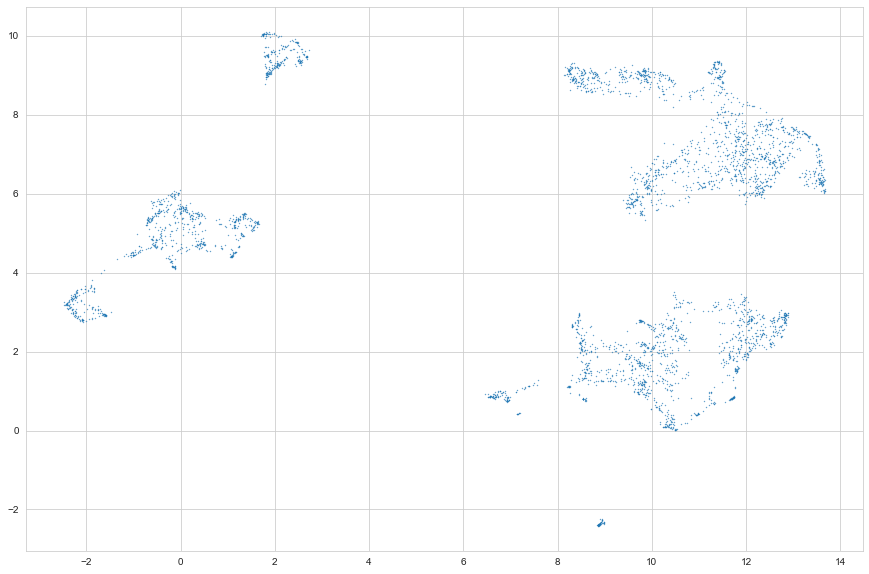

In [94]:
plt.figure(figsize=(15,10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')

Now, the big question is whether these clusters, which we have detected by the eye test, can be automatically detected by an unsupervised learning algorithm.

In [95]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=170,
).fit_predict(clusterable_embedding)

In [86]:
labels

array([ 6,  4, -1, ...,  0,  4,  6])

And indeed, the clustering algorithm has been able to detect the visible clusters, making the assignment of future profiles to these existing user profile cluster automatable. Thus our multivariate user segmentation has been successful.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


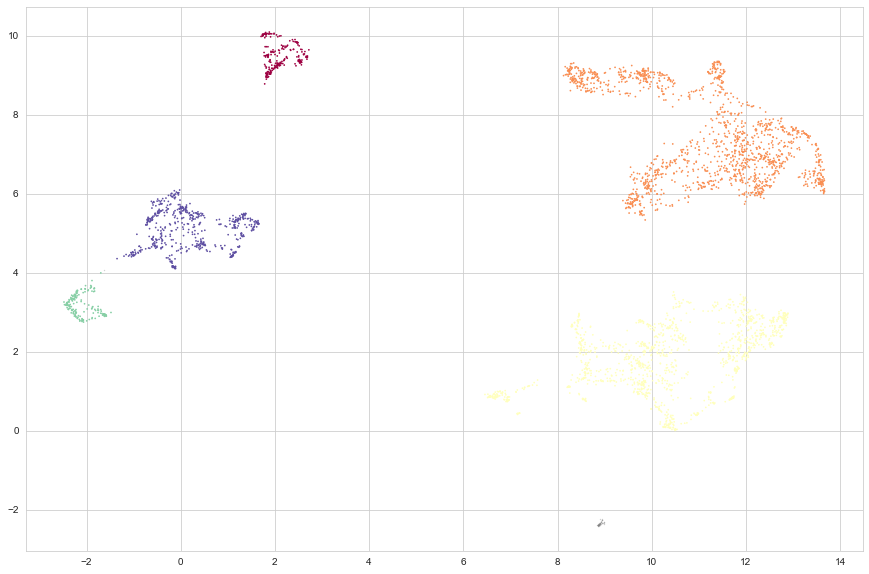

In [96]:
clustered = (labels >= 0)
plt.figure(figsize=(15,10))
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.5,
            cmap='Spectral');

# Predicting the average daily volume with a LSTM Neural Network

Preparing data for time series prediction w/ LSTM NN

In [31]:
volume_data = grp_total['total'].values

The test data will contain 82 days worth of data, which represents 25% of all data.

In [32]:
test_data_size = int(len(volume_data)*0.25)
test_data_size

17

In [35]:
train_data = volume_data[:-test_data_size]
test_data = volume_data[-test_data_size:]

Scaling data for easier handling and improving predictive performance

In [44]:
scal_lstm = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scal_lstm.fit_transform(volume_data .reshape(-1, 1))

In [45]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

The in_out_seqsfunction will accept the raw input data and will return a list of tuples. In each tuple, the first element will contain list of 10 items corresponding to the average volume in 10 days, the second tuple element will contain one item - the sum of revenue on the 10th+1st day.

In [46]:
train_window = 10

In [47]:
def in_out_seqs(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [48]:
train_inout_seq = in_out_seqs(train_data_normalized, train_window)

input_size: Corresponds to the number of features in the input. Though our sequence length is 10, for each day we have only 1 value - the average daily volume, therefore the input size will be 1.

hidden_layer_size: Specifies the number of hidden layers along with the number of neurons in each layer. We will have one layer of 100 neurons.

output_size: The number of items in the output, since we want to predict the average daily volume for 1 day in the future, the output size will be 1.

in the constructor we create variables hidden_layer_size, lstm, linear, and hidden_cell. LSTM algorithm accepts three inputs: previous hidden state, previous cell state and current input. The hidden_cell variable contains the previous hidden and cell state. The lstm and linear layer variables are used to create the LSTM and linear layers.

Inside the forward method, the input_seq is passed as a parameter, which is first passed through the lstm layer. The output of the lstm layer is the hidden and cell states at current time step, along with the output. The output from the lstm layer is passed to the linear layer. The predicted number of passengers is stored in the last item of the predictions list, which is returned to the calling function.

In [49]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=500, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

The next step is to create an object of the LSTM() class, define a loss function and the optimizer. Since, we are solving a regression problem, we will use the mean squared error loss. For the optimizer function, we will use the adam optimizer.

In [50]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Model training is 1000 epochs, with the loss printed out every 50th epoch. As you can see, probably more epochs and some parameter tuning is needed for better convergence, but for this showcase, this will suffice

In [51]:
epochs = 1000

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%50 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00494204
epoch:  51 loss: 0.00974941
epoch: 101 loss: 0.01129138
epoch: 151 loss: 0.01011067
epoch: 201 loss: 0.00484717
epoch: 251 loss: 0.00358842
epoch: 301 loss: 0.00407839
epoch: 351 loss: 0.00000021
epoch: 401 loss: 0.00031247
epoch: 451 loss: 0.00002696
epoch: 501 loss: 0.00303136
epoch: 551 loss: 0.00027205
epoch: 601 loss: 0.00009444
epoch: 651 loss: 0.00034696
epoch: 701 loss: 0.00042789
epoch: 751 loss: 0.00280167
epoch: 801 loss: 0.00000084
epoch: 851 loss: 0.00005083
epoch: 901 loss: 0.00000000
epoch: 951 loss: 0.00000906
epoch: 999 loss: 0.0004544989


Since our test set contains the average total volume data for the last 17 days and our model is trained to make predictions using a sequence length of 17. We will first filter the last 17 values from the training set:

In [52]:
fut_pred = test_data_size
test_inputs = train_data_normalized[-train_window:].tolist()

In [53]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

Since we normalized the dataset for training, the predicted values are also normalized. We need to convert the normalized predicted values into actual predicted values. We can do so by passing the normalized values to the inverse_transform method of the min/max scaler object that we used to normalize our dataset.

In [54]:
actual_predictions = scal_lstm.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

In [58]:
grp_total

,executed_at_date,total
0,2018-06-12,2073
1,2018-06-13,1999
2,2018-06-14,1874
3,2018-06-15,1959
4,2018-06-16,2241
...,...,...
64,2018-09-06,2069
65,2018-09-07,1986
66,2018-09-10,1929
67,2018-09-11,2123


In [59]:
x = np.arange(51, 68, 1)

In [60]:
grp_total.reset_index(inplace=True)

The predictions made by our LSTM are depicted by the orange line. You can see that our algorithm is not too accurate but still it has been able to capture the trend for total daily revenue in the last 82 days along with occasional fluctuations. You can try with a greater number of epochs and with a higher number of neurons in the LSTM layer to see if you can get better performance.

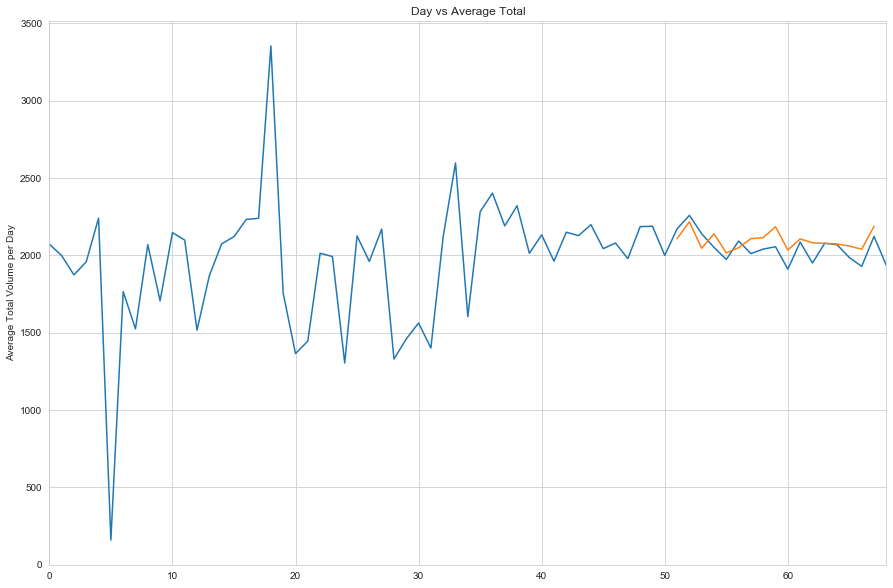

In [61]:
plt.figure(figsize=(15,10))
plt.title('Day vs Average Total')
plt.ylabel('Average Total Volume per Day')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(grp_total['total'])
plt.plot(x,actual_predictions)
plt.show()

Again, the predictions are not very accurate but the algorithm was able to capture the daily channel revenues movements in the future days with occasional fluctuations.

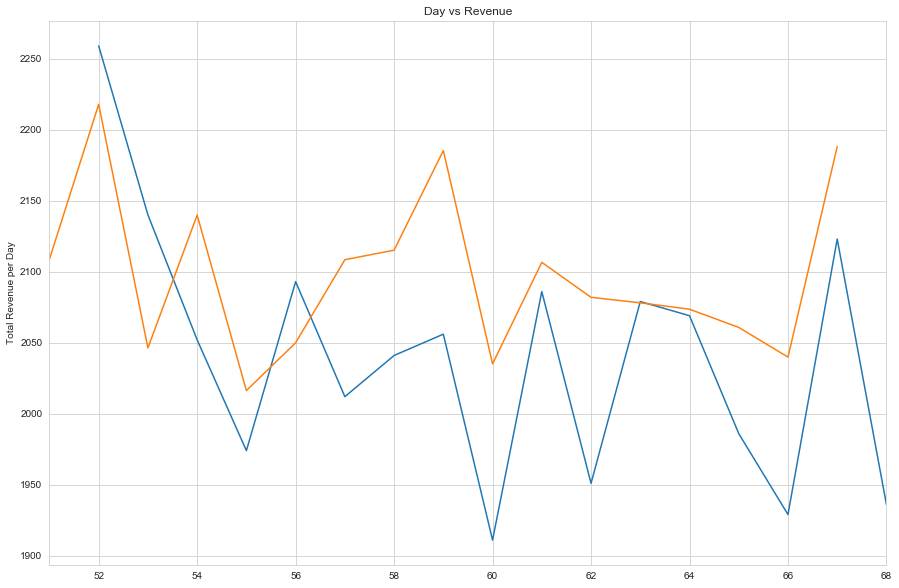

In [63]:
plt.figure(figsize=(15,10))
plt.title('Day vs Revenue')
plt.ylabel('Total Revenue per Day')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plt.plot(grp_total['total'][-test_data_size:])
plt.plot(x,actual_predictions)
plt.show()